In [1]:
import numpy as np
import torch
import open_clip
import csv
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt

/home/martin/Documents/MScProject/project_local/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
testsets = {
    "Progan" : ["progan_lsun"],
    "Biggan" : ["biggan_256","biggan_512"],
    "Gaugan" : ["gaugan"],
    "Stargan" : ["stargan"],
    "EG3D" : ["eg3d"],
    "Stylegan 2": ["stylegan2_afhqv2_512x512",
                   "stylegan2_ffhq_256x256",
                   "stylegan2_ffhq_1024x1024",
                   "stylegan2_lsundog_256x256",
                   "whichfaceisreal"],
    "Stylegan 3" : ["stylegan3_r_afhqv2_512x512",
                    "stylegan3_r_ffhqu_256x256",
                    "stylegan3_r_ffhqu_1024x1024",
                    "stylegan3_t_afhqv2_512x512",
                    "stylegan3_t_ffhqu_256x256",
                    "stylegan3_t_ffhqu_1024x1024"],
    "Taming Trans." : ["taming-transformers_class2image_ImageNet",
                             "taming-transformers_noise2image_FFHQ",
                             "taming-transformers_segm2image_valid"],
    "Dall-E Mini" : ["dalle-mini_valid"],
    "Dall-E 2" : ["dalle_2"],
    "Glide" : ["glide_text2img_valid"],
    "Guided Dif." : ["guided-diffusion_class2image_ImageNet",  
                "guided-diffusion_noise2image_LSUNbedrooms",
                "guided-diffusion_noise2image_LSUNcats",
                "guided-diffusion_noise2image_LSUNhorses"],
    "Latent Dif." : ["latent-diffusion_class2image_ImageNet",
                          "latent-diffusion_noise2image_FFHQ",
                          "latent-diffusion_noise2image_LSUNbedrooms",
                          "latent-diffusion_noise2image_LSUNchurches",
                          "latent-diffusion_text2img_valid"],
    "Stable Diff." : ["stable_diffusion_256"],
    "Stable Diff. v2" : ["stable_diffusion_512_50steps",
                             "stable_diffusion_512_100steps",
                             "stable_diffusion_512_200steps"],
    "DeepFakes" : ["deepfake"],
    "Pristine" : ["real_coco_valid", 
                  "real_imagenet_val", 
                  "real_ucid",
                  "ffhq",
                  "celebA",
                  ],
}

In [3]:
grag_accuracies = pandas.read_csv("data/grag_accuracies.csv", header=0, index_col=0)
vitL14_progan_openai = pandas.read_csv("data/progan-trained/vitL14_progan_openai+BLIP_100k_net_accuracies.csv", header=0, index_col=0)
vitL14_progan_openai_clip = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)
vitH14_progan_laion = pandas.read_csv("data/progan-trained/vitH14_progan_laion+BLIP_100k_net_accuracies.csv", header=0, index_col=0)
vitH14_progan_laion_clip = pandas.read_csv("data/progan-trained/vitH14_progan_laion_100k_net_accuracies.csv", header=0, index_col=0)
vitL14_stable_datacomp = pandas.read_csv("data/stable-trained/vitL14_stable_100k_datacomp+BLIP_net_accuracies.csv", header=0, index_col=0)
vitL14_stable_openai = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai+BLIP_net_accuracies.csv", header=0, index_col=0)
vitL14_stable_openai_clip = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai_net_accuracies.csv", header=0, index_col=0)

vitH14_fused_laion = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion+BLIP_net_accuracy.csv", header=0, index_col=0)
vitH14_fused_laion_clip = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)

models = [
    "Grag_2021",
    "Progan openai CLIP+BLIP",
    "Progan laion CLIP+BLIP",
    "Stable datacomp CLIP+BLIP",
    "Stable openai CLIP+BLIP",
    "Fused laion CLIP+BLIP",
    "Progan openai CLIP",
    "Stable openai CLIP",
    "Progan laion CLIP",
    "Fused laion CLIP",
    
]
colors = {
    "Grag_2021" : 'blue',
    "Progan openai CLIP+BLIP" : 'green',
    "Progan laion CLIP+BLIP" : 'orange',
    "Stable datacomp CLIP+BLIP" : 'purple',
    "Stable openai CLIP+BLIP" : 'green',
    "Progan openai CLIP" : 'gray',
    "Stable openai CLIP" : 'gray',
    "Progan laion CLIP" : 'gray',
    "Fused laion CLIP+BLIP": 'brown',
    "Fused laion CLIP": 'gray',
}

allsubmodels = []
for key in testsets:
    allsubmodels = allsubmodels + testsets[key]
print(allsubmodels)
tab_metrics = pandas.DataFrame(index=list(allsubmodels), columns = models)

for key in allsubmodels:
    tab_metrics.loc[key, "Grag_2021"] = grag_accuracies.loc[key, "Grag2021_progan"]
    tab_metrics.loc[key, "Progan openai CLIP+BLIP"] = vitL14_progan_openai.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan openai CLIP"] = vitL14_progan_openai_clip.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan laion CLIP+BLIP"] = vitH14_progan_laion.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan laion CLIP"] = vitH14_progan_laion_clip.loc[key + ".pt", "0.50"]
    tab_metrics.loc[key, "Stable datacomp CLIP+BLIP"] = vitL14_stable_datacomp.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Stable openai CLIP+BLIP"] = vitL14_stable_openai.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Stable openai CLIP"] = vitL14_stable_openai_clip.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Fused laion CLIP"] = vitH14_fused_laion_clip.loc[key + '.pt', "0.90"]
    tab_metrics.loc[key, "Fused laion CLIP+BLIP"] = vitH14_fused_laion.loc[key + '.pt', "0.85"]

def plot_raw_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        measurement = tuple([m * 100 for m in measurement])
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.legend(loc='upper center', ncols=len(models))
    ax.set_ylim(0,115)
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()

def plot_mean_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        pristine_mean = np.mean([tab_metrics.loc[subset, model] for subset in testsets["Pristine"]])
        measurement = [(m+pristine_mean)/ 2 * 100 for m in measurement]
        GAN_accuracy = np.mean(measurement[0:7])
        VQGAN_accuracy = np.mean(measurement[7:9])
        DM_accuracy = np.mean(measurement[7:-2])
        mean_accuracy = np.mean(measurement[:-1])
        print(f"{model} : GAN({GAN_accuracy}) VQGAN({VQGAN_accuracy} DM({DM_accuracy}) MEAN({mean_accuracy})")
        measurement = tuple(measurement)
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color = colors[model])
        ax.axhline(y = mean_accuracy, linestyle= ":", color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.legend(loc='upper center', ncols=len(models))
    ax.set_ylim(0,115)
    ax.axhline(y = 50, color = 'r', linestyle = '--')
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()
    

['progan_lsun', 'biggan_256', 'biggan_512', 'gaugan', 'stargan', 'eg3d', 'stylegan2_afhqv2_512x512', 'stylegan2_ffhq_256x256', 'stylegan2_ffhq_1024x1024', 'stylegan2_lsundog_256x256', 'whichfaceisreal', 'stylegan3_r_afhqv2_512x512', 'stylegan3_r_ffhqu_256x256', 'stylegan3_r_ffhqu_1024x1024', 'stylegan3_t_afhqv2_512x512', 'stylegan3_t_ffhqu_256x256', 'stylegan3_t_ffhqu_1024x1024', 'taming-transformers_class2image_ImageNet', 'taming-transformers_noise2image_FFHQ', 'taming-transformers_segm2image_valid', 'dalle-mini_valid', 'dalle_2', 'glide_text2img_valid', 'guided-diffusion_class2image_ImageNet', 'guided-diffusion_noise2image_LSUNbedrooms', 'guided-diffusion_noise2image_LSUNcats', 'guided-diffusion_noise2image_LSUNhorses', 'latent-diffusion_class2image_ImageNet', 'latent-diffusion_noise2image_FFHQ', 'latent-diffusion_noise2image_LSUNbedrooms', 'latent-diffusion_noise2image_LSUNchurches', 'latent-diffusion_text2img_valid', 'stable_diffusion_256', 'stable_diffusion_512_50steps', 'stable_d

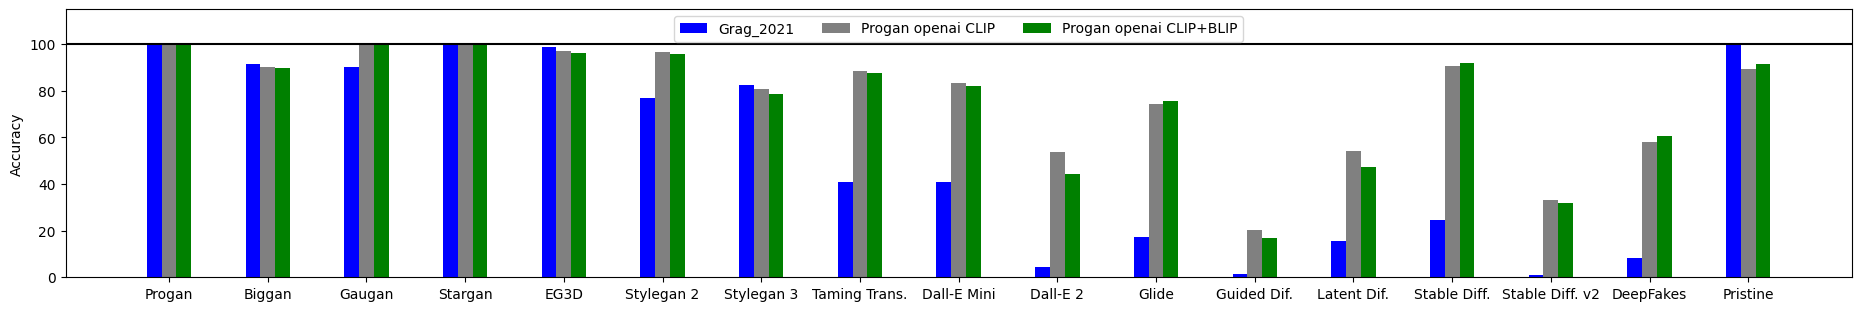

Grag_2021 : GAN(95.5696034581881) VQGAN(70.34995747873937 DM(60.22031462159651) MEAN(76.05140338025988)
Progan openai CLIP : GAN(92.16159178424802) VQGAN(87.65923504652176 DM(77.88477076080747) MEAN(83.43447374634957)
Progan openai CLIP+BLIP : GAN(92.91933231815769) VQGAN(88.19230084623777 DM(77.56849132242824) MEAN(83.67991553313372)


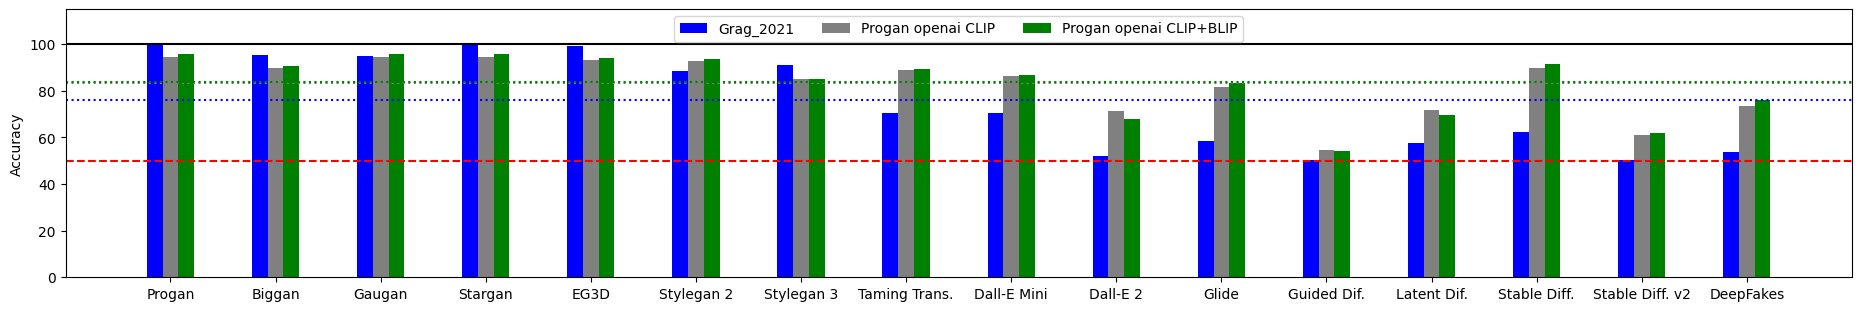

In [4]:
plot_sets = list(testsets.keys())
plot_models = ["Grag_2021", "Progan openai CLIP", "Progan openai CLIP+BLIP"]

plot_raw_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

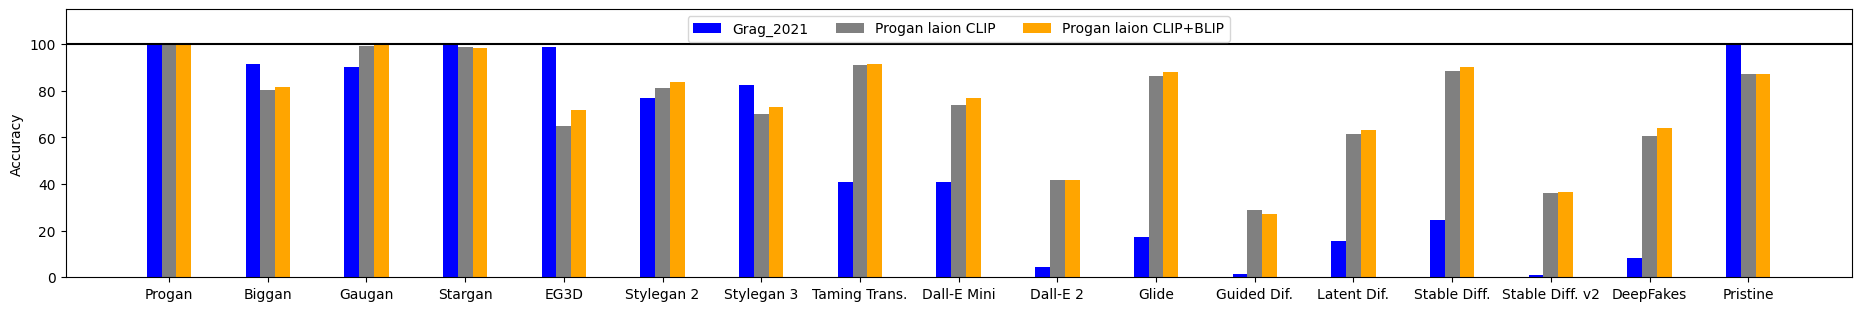

Grag_2021 : GAN(95.5696034581881) VQGAN(70.34995747873937 DM(60.22031462159651) MEAN(76.05140338025988)
Progan laion CLIP : GAN(86.13319187957894) VQGAN(84.84488631759825 DM(77.36161250807446) MEAN(80.41167891318925)
Progan laion CLIP+BLIP : GAN(87.13775589138541) VQGAN(85.88614552044334 DM(77.90965742520522) MEAN(81.15620258243852)


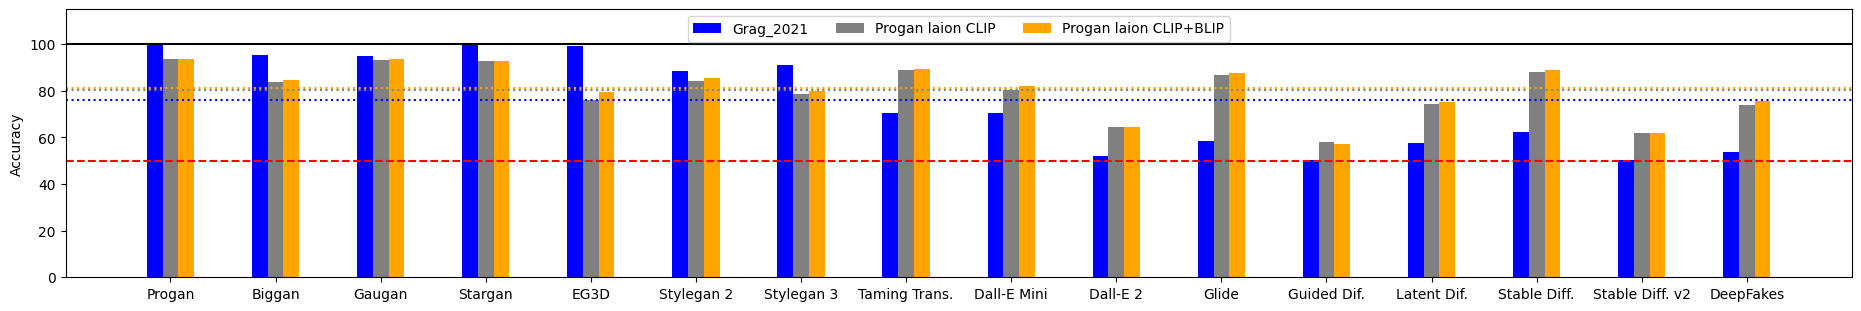

In [5]:
plot_sets = list(testsets.keys())
plot_models = ["Grag_2021", "Progan laion CLIP", "Progan laion CLIP+BLIP"]

plot_raw_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

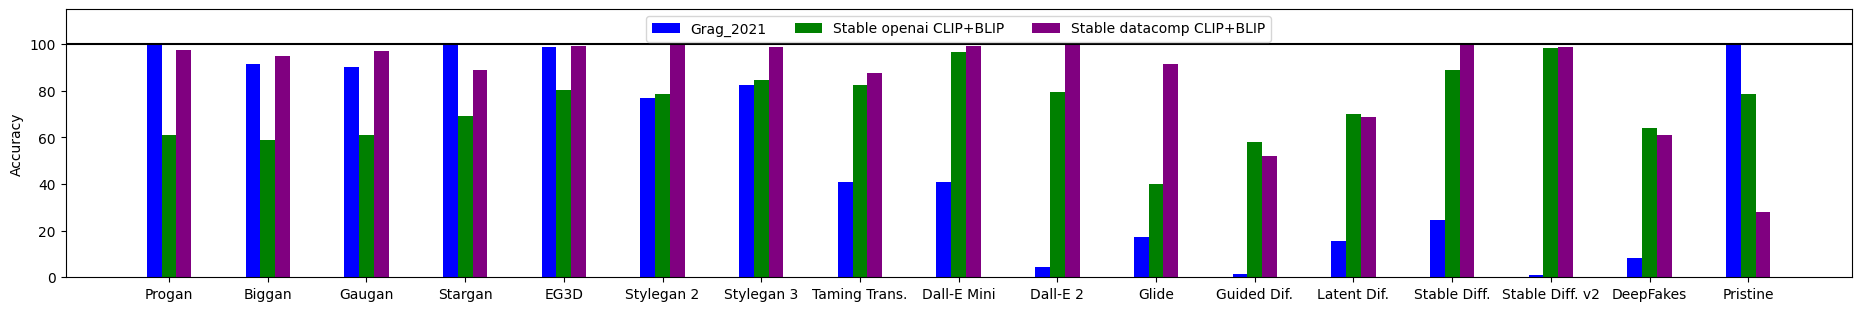

Grag_2021 : GAN(95.5696034581881) VQGAN(70.34995747873937 DM(60.22031462159651) MEAN(76.05140338025988)
Stable openai CLIP+BLIP : GAN(74.62365444208667) VQGAN(84.04073967850891 DM(76.15764444041368) MEAN(76.26343323484522)
Stable datacomp CLIP+BLIP : GAN(62.41157029113804) VQGAN(60.81222498618517 DM(56.86585593856613) MEAN(59.89694723960763)


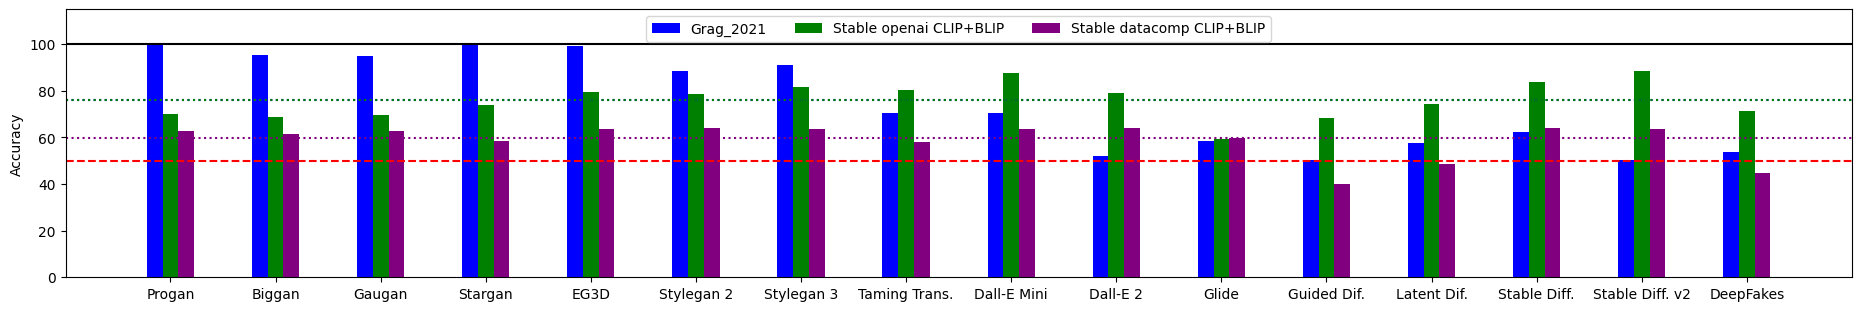

In [7]:
plot_sets = list(testsets.keys())
plot_models = ["Grag_2021", "Stable openai CLIP+BLIP", "Stable datacomp CLIP+BLIP"]

plot_raw_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

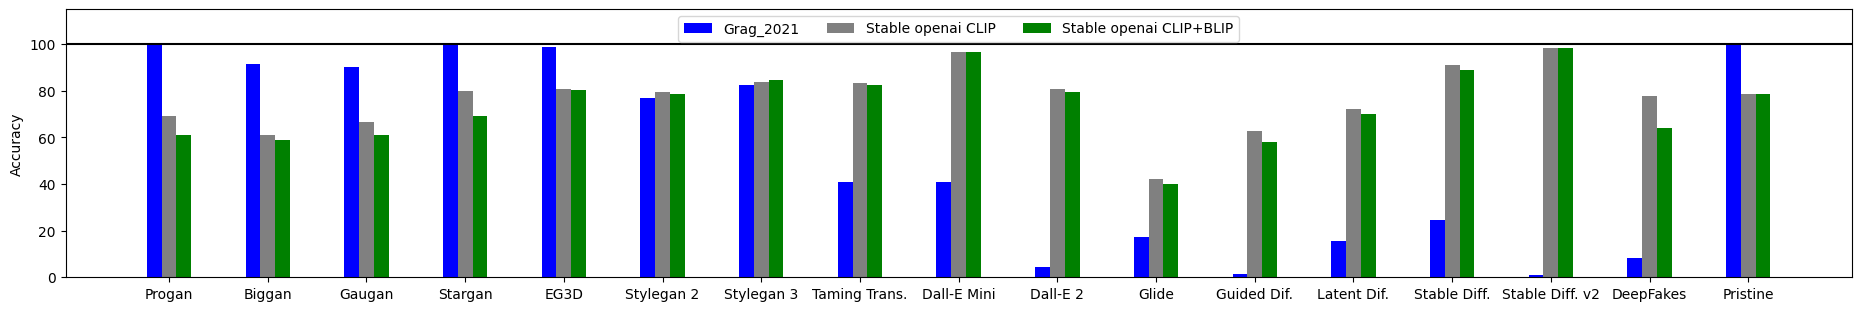

Grag_2021 : GAN(95.5696034581881) VQGAN(70.34995747873937 DM(60.22031462159651) MEAN(76.05140338025988)
Stable openai CLIP : GAN(76.63650430499649) VQGAN(84.38373423782144 DM(77.16492471401192) MEAN(77.68124915805869)
Stable openai CLIP+BLIP : GAN(74.62365444208667) VQGAN(84.04073967850891 DM(76.15764444041368) MEAN(76.26343323484522)


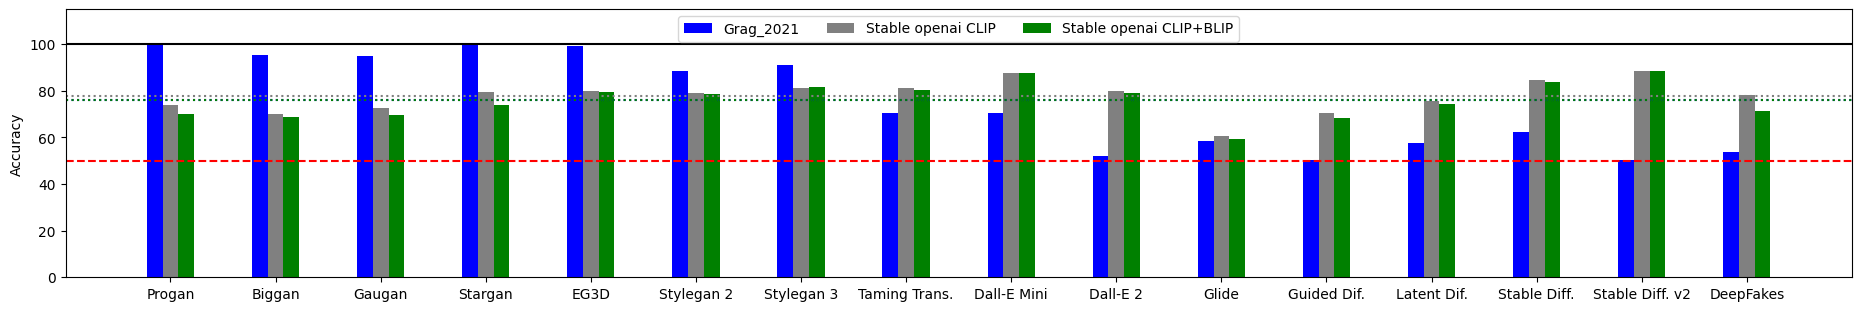

In [9]:
plot_sets = list(testsets.keys())
plot_models = ["Grag_2021", "Stable openai CLIP", "Stable openai CLIP+BLIP"]

plot_raw_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

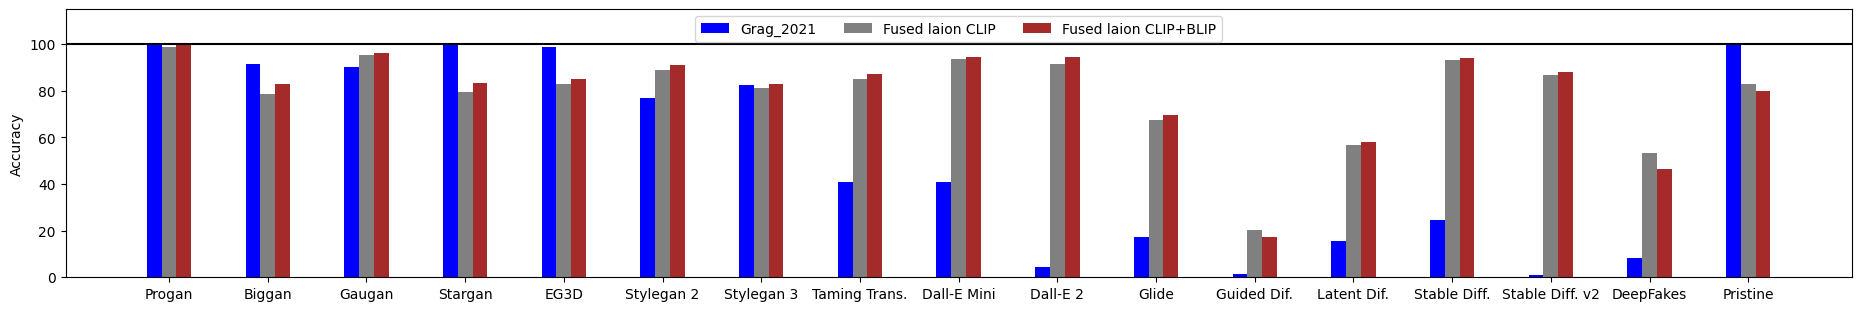

Grag_2021 : GAN(95.5696034581881) VQGAN(70.34995747873937 DM(60.22031462159651) MEAN(76.05140338025988)
Fused laion CLIP : GAN(84.66135297203414) VQGAN(86.1342937215992 DM(77.70000800731349) MEAN(81.42147692735774)
Fused laion CLIP+BLIP : GAN(84.40796230834692) VQGAN(85.47415720939692 DM(76.85249054273027) MEAN(80.8653773666847)


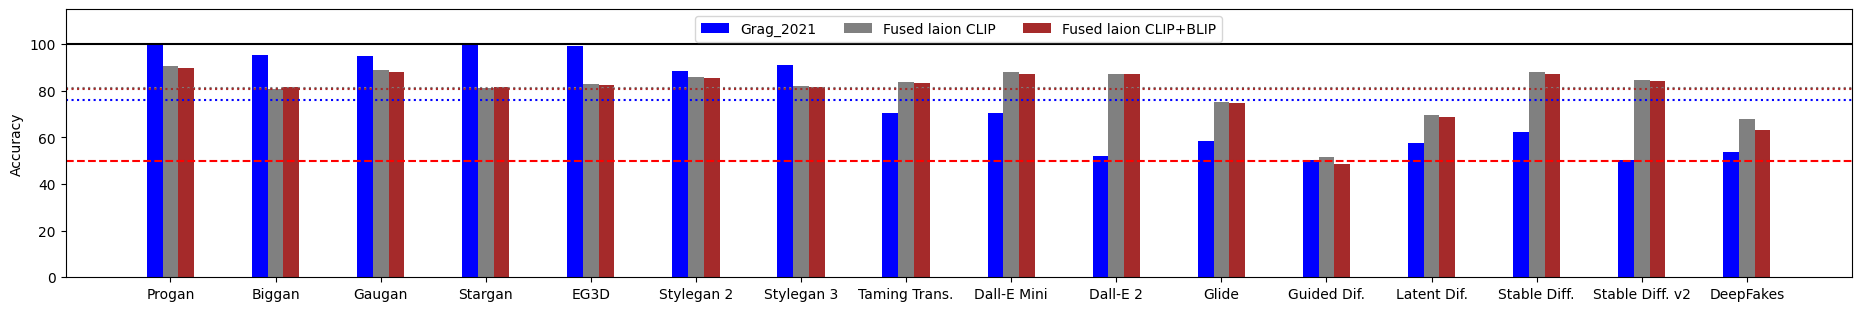

In [10]:
plot_sets = list(testsets.keys())
plot_models = ["Grag_2021", "Fused laion CLIP", "Fused laion CLIP+BLIP"]

plot_raw_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, width=0.15, multiplier=0)